In [5]:
import pandas as pd
%matplotlib inline

In [6]:
import os
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling/data_augmentation


In [7]:
#os.chdir('AnomaliesRecycling')
os.chdir('..')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling


In [32]:
import pandas as pd
synthesized_csv = pd.read_csv("./data/labels/synthesized/synthesized.csv")
train_csv = pd.read_csv("./data/train.csv")

In [27]:
synthesized_csv.head()

,name,count,synthesized
0,synthesized/label_0_img_0.jpg,0,True
1,synthesized/label_0_img_1.jpg,0,True
2,synthesized/label_0_img_2.jpg,0,True
3,synthesized/label_0_img_3.jpg,0,True
4,synthesized/label_0_img_4.jpg,0,True


In [33]:
train_csv = pd.concat([train_csv, synthesized_csv])
train_csv.head()

,name,count,edge,different colors,one color,transparent,inside,overlapping,dark color,open lid,synthesized
0,cluttered/Anlerndaten (568).jpg,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
1,presorted/trial (1544).jpg,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2,presorted/trial (1673).jpg,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,cluttered/Anlerndaten (454).jpg,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
4,cluttered/Anlerndaten (184).jpg,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [42]:
train_csv = train_csv.fillna(0)
train_csv.to_csv('./data/train.csv', index=False)


Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [43]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

from src.transfer_learning import TransferLearningTrainer
from src.cam import CAM


plt.ion()   # interactive mode

In [44]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device_count()

1

Load Data and Data Augmentation
---------

In [45]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(degrees=(0, 180)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #transforms.RandomSolarize(threshold=0.5),
        #transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [46]:
transferLearningTrainer = TransferLearningTrainer(data_transforms=data_transforms)

Visualize a few images



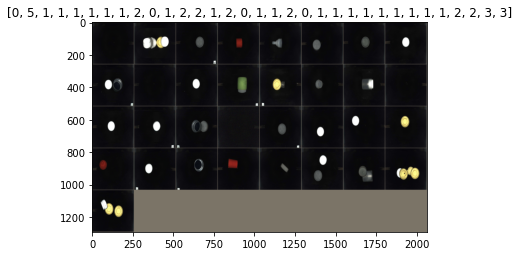

In [47]:
# Get a batch of training data
sample = next(iter(transferLearningTrainer.dataloaders['train']))
inputs, classes = sample['image'], sample['label']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
transferLearningTrainer.imshow(out, [transferLearningTrainer.class_names[x] for x in classes])

Training the model
------------------

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [48]:
model_name = "ResNet18_synthesized"
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [52]:
model_ft = torch.load(transferLearningTrainer.MODELS_DIR + 'GoogleNet_SOS_model.pth')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [54]:
model_ft = transferLearningTrainer.train_model(model=model_ft,
                                               criterion=criterion,
                                               optimizer=optimizer_ft,
                                               scheduler=exp_lr_scheduler,
                                               num_epochs=50,
                                               model_name="GoogleNet_SOS_model_synthesized",
                                               early_stop=False)

Epoch 0/49
----------
train Loss: 0.3034 Acc: 0.8919
test Loss: 0.3921 Acc: 0.8589

Epoch 1/49
----------
train Loss: 0.2263 Acc: 0.9220
test Loss: 0.3147 Acc: 0.8949

Epoch 2/49
----------
train Loss: 0.1747 Acc: 0.9427
test Loss: 0.3093 Acc: 0.9024

Epoch 3/49
----------
train Loss: 0.1369 Acc: 0.9575
test Loss: 0.3146 Acc: 0.9039

Epoch 4/49
----------
train Loss: 0.1112 Acc: 0.9662
test Loss: 0.3276 Acc: 0.9024

Epoch 5/49
----------
train Loss: 0.0875 Acc: 0.9758
test Loss: 0.2476 Acc: 0.9279

Epoch 6/49
----------
train Loss: 0.0730 Acc: 0.9810
test Loss: 0.2503 Acc: 0.9264

Epoch 7/49
----------
train Loss: 0.0607 Acc: 0.9852
test Loss: 0.2545 Acc: 0.9174

Epoch 8/49
----------
train Loss: 0.0544 Acc: 0.9865
test Loss: 0.2669 Acc: 0.9159

Epoch 9/49
----------
train Loss: 0.0441 Acc: 0.9885
test Loss: 0.2579 Acc: 0.9159

Epoch 10/49
----------
train Loss: 0.0414 Acc: 0.9898
test Loss: 0.2377 Acc: 0.9234

Epoch 11/49
----------
train Loss: 0.0381 Acc: 0.9904
test Loss: 0.2389 Acc

 ***Train and evaluate***

In [49]:
model_ft = transferLearningTrainer.train_model(model=model_ft,
                                               criterion=criterion,
                                               optimizer=optimizer_ft,
                                               scheduler=exp_lr_scheduler,
                                               num_epochs=50,
                                               model_name=model_name,
                                               early_stop=False)

Epoch 0/49
----------
train Loss: 0.5694 Acc: 0.7955
test Loss: 0.3860 Acc: 0.8604

Epoch 1/49
----------
train Loss: 0.2518 Acc: 0.9132
test Loss: 0.5547 Acc: 0.7628

Epoch 2/49
----------
train Loss: 0.1743 Acc: 0.9438
test Loss: 0.9545 Acc: 0.4985

Epoch 3/49
----------
train Loss: 0.1235 Acc: 0.9609
test Loss: 0.7877 Acc: 0.6051

Epoch 4/49
----------
train Loss: 0.0928 Acc: 0.9720
test Loss: 0.2703 Acc: 0.9009

Epoch 5/49
----------
train Loss: 0.0690 Acc: 0.9806
test Loss: 0.2461 Acc: 0.9099

Epoch 6/49
----------
train Loss: 0.0554 Acc: 0.9838
test Loss: 0.5931 Acc: 0.7447

Epoch 7/49
----------
train Loss: 0.0398 Acc: 0.9882
test Loss: 1.1459 Acc: 0.5255

Epoch 8/49
----------
train Loss: 0.0363 Acc: 0.9887
test Loss: 0.2498 Acc: 0.9039

Epoch 9/49
----------
train Loss: 0.0281 Acc: 0.9915
test Loss: 0.4079 Acc: 0.8468

Epoch 10/49
----------
train Loss: 0.0245 Acc: 0.9930
test Loss: 0.2100 Acc: 0.9384

Epoch 11/49
----------
train Loss: 0.0220 Acc: 0.9944
test Loss: 0.2138 Acc

/cvhci/temp/p22g5/data/harder_samples/Anlernbilder (230).jpg


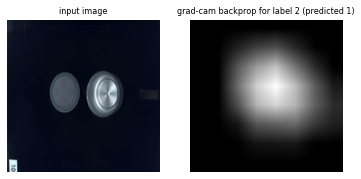

In [9]:
model_name += "_weights.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = torch.nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
model_ft.load_state_dict(torch.load(transferLearningTrainer.MODELS_DIR + model_name))
# print(model_ft)

cam = CAM(transferLearningTrainer)
cam.print_cam(model_ft)

In [ ]:
!reload_ext tensorboard
!tensorboard --logdir /cvhci/temp/p22g5/runs/

***Filenames where validation failed***

In [11]:
_ = transferLearningTrainer.print_misclassified(model_ft, plot=True)

cluttered/Anlerndaten (830).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (460).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (154).jpg
must be 5, but predicted 4
harder_samples/Anlernbilder (338).jpg
must be 3, but predicted 2
cluttered/Anlerndaten (875).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (161).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (171).jpg
must be 3, but predicted 2
presorted/trial (127).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (764).jpg
must be 1, but predicted 0
cluttered/Anlerndaten (615).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (465).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (193).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (149).jpg
must be 3, but predicted 2
presorted/trial (1326).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (362).jpg
must be 4, but predicted 2
harder_samples/Anlernbilder (88).jpg
must be 3, but predicted 2
harder_samples/Anlernbilde

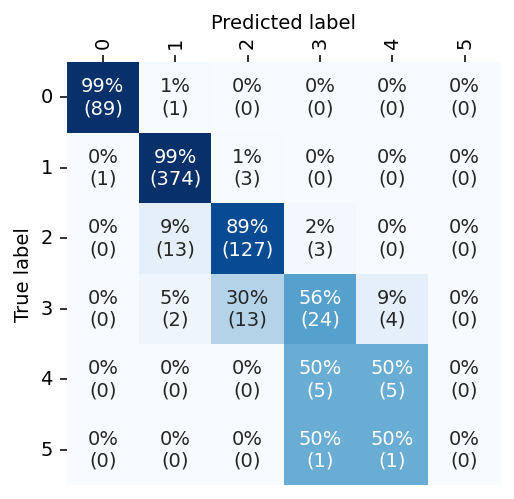

In [55]:
transferLearningTrainer.print_confusion_matrix(model_ft)

ConvNet as fixed feature extractor
----------------------------------

In [ ]:
model_name = "ResNet18_test"
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = transferLearningTrainer.train_model(model_conv,
                                                 criterion,
                                                 optimizer_conv,
                                                 exp_lr_scheduler,
                                                 num_epochs=50,
                                                 model_name=model_name)

In [ ]:
transferLearningTrainer.visualize_model(model_conv)